# Image Classification model for the Caltech-UCSD Birds-200-2011 dataset

In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


from tqdm import tqdm
import PIL.Image as Image

if not os.path.isdir('./experiments'):
    os.makedirs('./experiments')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("torch.cuda.is_available() : ", torch.cuda.is_available())

torch.cuda.is_available() :  True


In [2]:
batch_size = 25 #64
epochs = 90
model_momentum = 0.5
model_lr = 1e-3
model_log_interval = 10

# Data Loading & Model creation

total training images: 44
total validation images: 5
total test images: 517


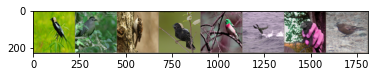

In [3]:
data_transforms = transforms.Compose([
    #transforms.RandomRotation(degrees = 10),
    transforms.RandomResizedCrop(224, scale=(0.8, 0.8)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('../input/mva-recvis-2021/bird_dataset/train_images', transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('../input/mva-recvis-2021/bird_dataset/val_images',transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('../input/mva-recvis-2021/bird_dataset/test_images',transform=data_transforms),
    batch_size=1, shuffle=False, num_workers=1)


# Sanity checks
print('total training images:', len(train_loader))
print('total validation images:', len(val_loader))
print('total test images:', len(test_loader))


def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    
n_images_train = 8
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[0:n_images_train])

imshow(out)

In [4]:
# MODEL

nclasses = 20 


model = torchvision.models.resnext101_32x8d(pretrained = True)
#model = coatnet_0()
#model = torchvision.models.resnet152(pretrained=True)   
#model = torchvision.models.resnet101(pretrained=True)
#model = torchvision.models.resnet50(pretrained=True)
#model = torchvision.models.googlenet(pretrained=True)
##model = torchvision.models.vgg16(pretrained=True)

for (name, layer) in model._modules.items():
    print(name)
    layer.trainable = True
    
layers_to_be_freezed = []
layers_to_be_trained = ['conv1','bn1','relu','maxpool', 'layer1', 'layer2', 'layer3', 'layer4','avgpool', 'fc']

"""
for (name, layer) in model._modules.items():
    #if name in ['s0', 's1', 's2', 's3', 's4']:
    if name in ['conv1','bn1','relu','maxpool', 'layer1', 'layer2', 'layer3', 'layer4','avgpool']:
        layer.trainable = False
        print(name, "is not trained")
    #elif name in layers_to_be_trained:
    else:
        layer.trainable = True
        print(name, "is trained")
      #else:
        #print(name, "not recognized")
        #break
"""

num_feats = model.fc.in_features
class Add_layers(nn.Module):
    def __init__(self):
        super(Add_layers, self).__init__()
        self.drop = torch.nn.Dropout(p = 0.5)
        self.fc1 = nn.Linear(num_feats, nclasses)

    def forward(self, x):
        x = self.drop(x)
        x = self.fc1(x)
        return x

model.fc = Add_layers()

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=model_lr, momentum = model_momentum, weight_decay=5*1e-4)
#optimizer = optim.Adam(model.parameters(), lr=model_lr, weight_decay=5*1e-4) 


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [5]:
# Both classes below are from https://colab.research.google.com/drive/1krRZ-VVfpXUsHk3JFCjBtYUiUOwL8vW0?usp=sharing#scrollTo=lb9cXgakK-jg

class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=4, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)
    

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [6]:
lr_scheduler_bool = True
early_stopping_bool = True

if lr_scheduler_bool == True:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
if early_stopping_bool == True:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()

INFO: Initializing learning rate scheduler
INFO: Initializing early stopping


# Train

In [7]:
use_cuda = torch.cuda.is_available()

def train(epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        if use_cuda:
            data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        #forward
        preds = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % model_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))


def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        if use_cuda:
            data, target = data.to(device), target.to(device)
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    if lr_scheduler_bool == True:
        lr_scheduler(validation_loss)
    if early_stopping_bool == True:
        early_stopping(validation_loss)
        if early_stopping.early_stop:
            print("INFO : EARLY STOP")
            break_because_early_stop = True
        else:
            break_because_early_stop = False
    return break_because_early_stop


In [8]:
#! pip install skorch 

In [9]:
torch.manual_seed(42)
for epoch in range(1, epochs + 1):
    print("################################################# EPOCH", epoch)
    train(epoch)
    bool_early_stop = validation()
    model_file = 'experiments' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')
    if bool_early_stop == True:
        print("EARLY STOP NOW")
        break
        

################################################# EPOCH 1
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.936417
Train Epoch: 1 [250/1082 (23%)]	Loss: 2.851863
Train Epoch: 1 [500/1082 (45%)]	Loss: 2.957521
Train Epoch: 1 [750/1082 (68%)]	Loss: 2.934865
Train Epoch: 1 [1000/1082 (91%)]	Loss: 2.803643

Validation set: Average loss: 0.1288, Accuracy: 39/103 (38%)
Saved model to experiments/model_1.pth. You can run `python evaluate.py --model experiments/model_1.pth` to generate the Kaggle formatted csv file

################################################# EPOCH 2
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.839378
Train Epoch: 2 [250/1082 (23%)]	Loss: 2.720223
Train Epoch: 2 [500/1082 (45%)]	Loss: 2.581077
Train Epoch: 2 [750/1082 (68%)]	Loss: 2.543879
Train Epoch: 2 [1000/1082 (91%)]	Loss: 2.356659

Validation set: Average loss: 0.1091, Accuracy: 65/103 (63%)
Saved model to experiments/model_2.pth. You can run `python evaluate.py --model experiments/model_2.pth` to generate the Kaggle formatted csv file

# Test

In [10]:
print(model_file)
preds = np.array([])
model.eval()
with torch.no_grad():
    for i, (data, labels) in tqdm(enumerate(test_loader, 0)):
        data, labels = data.to(device), labels.to(device)
        output1 = model(data)
        sm = nn.Softmax(dim=1)(output1)
        pred = sm.max(1, keepdim=True)[1]    
        preds = np.hstack((preds, torch.squeeze(pred).cpu().numpy()))

experiments/model_30.pth


517it [00:15, 34.20it/s]


In [11]:
f = open("submission.csv", "w")
f.write("Id,Category\n")
for (n,_),p in zip(test_loader.dataset.samples,preds):
    f.write("{},{}\n".format(n.split('/')[-1].split('.')[0], int(p)))
f.close()
print(("{},{}\n".format(n.split('/')[-1].split('.')[0], int(p))))

ffe6dc708419b819ea897d666e986ec6,8

